### **Code with CUDA (Part1)**




For our introduction to CUDA, we will use Google Colab which offers free GPU support.

Today, we will set up the minimalistic environment needed to run our CUDA code directly on Colab and get started.

In this notebook, we will follow five steps:

1. Connect the notebook to a runtime environment (T4 GPU)
2. Mount the drive you are using
3. Install and register nvcc4juyter
4. Say “hello world” in Cuda
5. Perform matrix addition in CUDA

Let’s get started!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-0jyhxdts
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-0jyhxdts
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 28f872a2f99a1b201bcd0db14fdbc5a496b9bfd7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10743 sha256=3a570d3ab74e9051a615aa78d54722c78a69a0c83a1d407fccde14c37a30e96c
  Stored in directory: /tmp/pip-ephem-wheel-cache-t2vwz2lu/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter


## Install Nvcc4jupyter

It's a tool design to enable the use of NVIDIA's CUDA directly within Jupyter notebooks.

In [ ]:
# Install nvcc4jupyter and store the result in our drive...then you don't necessarily need to install it again
!pip install -t "/content/drive/My Drive/nvcc4jupyter" git+https://github.com/andreinechaev/nvcc4jupyter.git

# call the path
import sys
sys.path.append('/content/drive/My Drive/nvcc4jupyter')

# load nvcc4jupyter
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp44rorb3m".


## CUDA Overview

Here we will outline the main concepts behind the CUDA programming model (focusing on how they are exposed in C). A more in-depth explanation can be found in the [official programming guide](http://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html).

* **host** - CPU and RAM

* **device** - GPU and it's RAM

* **kernels** - special functions, which can be called from host code (regular C code running on the CPU) but are run on the device (GPU) N times in parallel, executed by N CUDA threads.

* **\__global__** - special CUDA C keyword used as part of a method signature to mark that method as a kernel.

* **\__host__** - methods marked with this keyword can be only called from host code and will also run on the host

* **\__device__** - methods marked with this keyword can be only called from device code and will also run on the device

As already mentioned, CUDA and GPUs are highly scalable and parallel thanks to their multithread-first programming model. Kernels are executed N times in separate threads, which are for convenience, grouped in a hierarchy of blocks and grids:

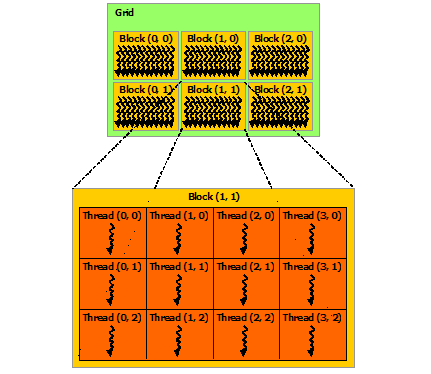![grid-of-thread-blocks]

* **thread block** - CUDA programming model follows a well defined thread hierarchy model in which threads during execution are grouped into so called thread blocks. Thread blocks can be one, two or three dimensional. This very naturally maps to vectors, matrices and volumes.

There's a limit of threads per block since 1) all the threads in a block are expected to reside on the same processor core 2) have to share very limited resources of said core.

We can run a kernel, though, using multiple blocks each with the same number of threads. The total number of threads per kernel in such a case will be number_of_blocks * number_of_threads_per_block.

* **threadIdx.{x,y,z}** - similar to the above these variables identify the thread ID that is being executed with the current block.

* **blockIdx.{x,y,z}** - these 3 special, read-only, variables can be used within CUDA kernels to find out which block is executing the code at a given time. This, and the following read-only variables, are usually used to identify which part of data should be handled by a given kernel instance as there will be N of them running in parallel.

* **blockDim.{x,y,z}** - another special read-only variable accesible within CUDA kernels. Contrary to the previous ones these are constant and describe the total number of threads within a block.

* **grid** - similarly to threads being organized in thread blocks, thread blocks are organized into one, two or three dimensional grids. The number of blocks is dictated by the size of data and/or number of processors available.

* **methodName <<< blocks, threads_per_block>>> (parameters)** - this is how you launch a kernel. You use this syntax in your host code (regular C code which runs on the CPU) but it is executed on the device (GPU). There are numerous variants of this operator but the most basic one takes in 2 numbers: the number of blocks to run on the GPU and the second the number of threads per each block.

Running tasks on the GPU could be visualized as:

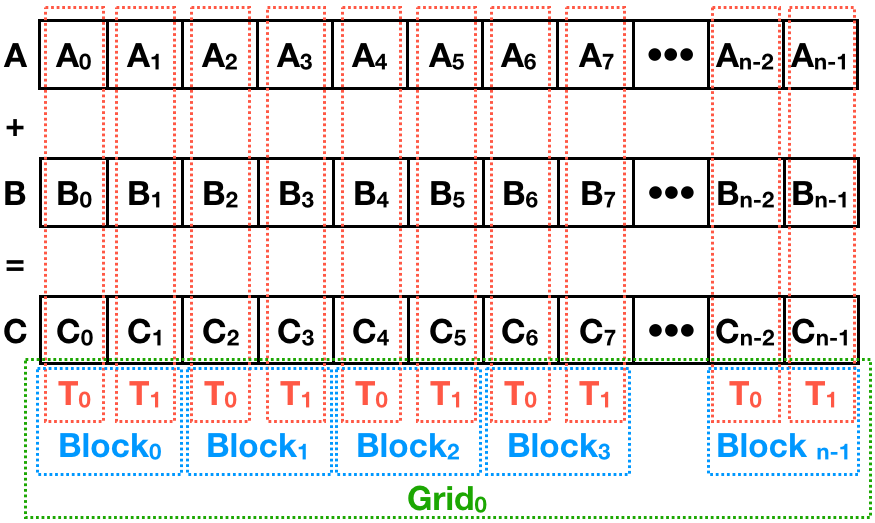

Architecting our applications in such a way allows GPUs to take advantage of Streaming Multiprocessors (SMs) which are one of the base elements of modern GPUs (whic are built arround an array of SMs). Scheduler automatically assignes blocks to free SMs as resources become available. Thanks to this your applications will run faster on more powerful GPUs without any changes in code.

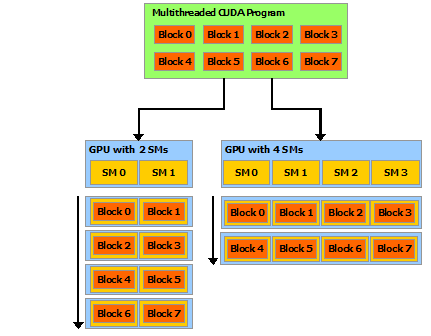

In [ ]:
%%cuda
#include <stdio.h>

  // GPU function
__global__ void helloFromGPU(void) {
    printf("Hello World from GPU!\n");
}

int main(void) {
    // execute function
    helloFromGPU<<<1, 10>>>();

    cudaDeviceSynchronize();

    printf("Hello World from CPU!\n");

    return 0;
}
// psss we call ten threads per block cause I want to show our threads & blocks works...for a simple hello world, just call 1 block and one thread


Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from GPU!
Hello World from CPU!



## Matrix addition


In [ ]:
from ctypes import sizeof

In [ ]:
%%cuda

// Include standard I/O and math libraries
// Define N as the size of the arrays (number of elements processed by the GPU)
#include <stdio.h>
#include <math.h>

#define N 16
// define Global function that run on the GPU

__global__ void add(int* a, int* b, int* c) {
    // Kernel function executed on the GPU
    // Calculate the Global index for each thread
    int localIdx = blockIdx.x * blockDim.x + threadIdx.x;

    // Ensure the thread index is within bounds before performing the addition
    if (localIdx < N) {
      c[localIdx] = a[localIdx] + b[localIdx];
    }

}

int main( int argc, char** argv ) {
    // Declare host (CPU) arrays and corresponding GPU pointers
    int a[N], b[N], c[N];
    int *dev_a, *dev_b, *dev_c;

    // Initialize host arrays with sample values
    // Array a will contain even numbers, array b will contain negatives
    for (int i=0; i < N; i++) {
        a[i] = 2*i;
        b[i] = -i;
    }
    // Allocate memory space for variables onto GPU
    cudaMalloc( (void**)&dev_a, N * sizeof(int) );
    cudaMalloc( (void**)&dev_b, N * sizeof(int) );
    cudaMalloc( (void**)&dev_c, N * sizeof(int) );

    //Copy data from the host CPU to device GPU for operations
    cudaMemcpy( dev_a, a, N * sizeof(int), cudaMemcpyHostToDevice );
    cudaMemcpy( dev_b, b, N * sizeof(int), cudaMemcpyHostToDevice );

    // Configure the number of threads per block and number of blocks
    // Maximum threads per block is 1024 (hardware limit)
    // Calculate the number of blocks needed based on the size of the arrays
    int threadsPerBlock = 1024;
    int blocks = (int)ceil((float)N / threadsPerBlock);


    // Launch the kernel to perform addition on the GPU
    add<<< blocks,threadsPerBlock >>>(dev_a, dev_b, dev_c);

    // Copy the result from GPU (device) memory back to CPU (host) memory
    cudaMemcpy( c, dev_c, N * sizeof(int), cudaMemcpyDeviceToHost );

    // Print the result of the addition for each element
    for (int i=0; i < N; i++) {
        printf( "%d + %d = %d\n", a[i], b[i], c[i] );
    }


    // Free allocated GPU memory to avoid memory leaks
    cudaFree( dev_a );
    cudaFree( dev_b );
    cudaFree( dev_c );

    return 0;
}

0 + 0 = 0
2 + -1 = 1
4 + -2 = 2
6 + -3 = 3
8 + -4 = 4
10 + -5 = 5
12 + -6 = 6
14 + -7 = 7
16 + -8 = 8
18 + -9 = 9
20 + -10 = 10
22 + -11 = 11
24 + -12 = 12
26 + -13 = 13
28 + -14 = 14
30 + -15 = 15

